In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, OrdinalEncoder 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import joblib

from sklearn.metrics import r2_score, accuracy_score
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from pandas import DatetimeIndex as dt

%matplotlib inline
plt.style.use('bmh')

In [2]:
supermarket = pd.read_csv('supermarket_sales.csv')

In [3]:
supermarket = supermarket.drop(['City','Invoice ID','gross margin percentage','cogs', 'Total', 'Rating'], axis=1)

In [4]:
train_data, test_data = train_test_split(supermarket, test_size=0.2, random_state=0)

train_data.shape, test_data.shape

((800, 10), (200, 10))

Question 1

In [5]:
### Pipeline for predicting gross income
 # Build a custom transformer

class AttributesOrganizer(): 
    def __init__ (self): 
        return
        
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        # Integer Encoding for Time of the Day
        # 1. Morning (10:00 - 11:59), 2. Afternoon (12:00 - 16:59)
        # 3. Evening (17:00 - 18:59), 4. Night (19:00 - 20:59)
        hour = pd.to_datetime(X['Time']).dt.strftime('%H').astype('float')
        hour_cat = pd.cut(hour, bins=[0., 12.0, 16.0, 18.0, np.inf], labels=[1, 2, 3, 4])
        
        # Integer Encoding for Day of the Week
        # 0. Monday, 1. Tuesday, 2. Wednesday, 3. Thursday 4. Friday, 5. Saturday, 6. Sunday
        day_of_week = pd.to_datetime(X['Date']).dt.dayofweek
        
        # Drop the original time and date attributes and add the encoded versions
        X = X.drop(['Time','Date'],axis=1)
        X['time_of_day'] = hour_cat
        X['day_of_week'] = day_of_week
        return X

# Pipeline for adding encoded versions of time of day and day of week
attribute_organizer = Pipeline([('attribs_organizer', AttributesOrganizer())]) 

# List of numerical and categorical attributes (as outputted by "AttributesOrganizer")
#'Unit price',
# 'Quantity', 'Total', 'cogs', 'Rating'
#'Branch','Customer type','Date','Time','Payment','Gender','Product line'
cat_1hot_attribs = ['Branch', 'Product line','Payment','time_of_day','day_of_week']
cat_int_attribs = ['Gender','Customer type']
num_2scale_attribs = ['Quantity','Unit price']
num_orig_attribs = ['gross income']

# purposefully leaving "Invoice ID" and "gross margin percentage" out

# Pipeline for categorical attributes to be represented as one-hot encoding
cat_1hot_pipeline = Pipeline([('one_hot_encode', OneHotEncoder())])

# Pipeline for categorical attributes to be represented as integer encoding
cat_int_pipeline = Pipeline([('integer_encode', OrdinalEncoder())])

# Pipeline for numerical attributes to be scaled
num_2scale_pipeline = Pipeline([('std_scaler', StandardScaler())]) 

# Pipeline for numerical attributes to keep as original (target variables)
num_orig_pipeline = Pipeline([('missing_values',SimpleImputer(strategy='median'))]) 

# Attributes Pipeline
attributes_encoder_and_scaling = ColumnTransformer([('cat_1hot', cat_1hot_pipeline, cat_1hot_attribs),
                                                    ('cat_int', cat_int_pipeline, cat_int_attribs),
                                                    ('num_2scale', num_2scale_pipeline, num_2scale_attribs),
                                                    ('num_targets', num_orig_pipeline, num_orig_attribs)],
                                                  remainder='drop') 

# Full Pipeline (Attributes organizer followed by attributes encoder)
preprocessing_pipeline = Pipeline([('attributes', attribute_organizer),
                                  ('encod_and_scale', attributes_encoder_and_scaling)])

train_set_prepared_gross = preprocessing_pipeline.fit_transform(train_data)
test_set_prepared_grpss = preprocessing_pipeline.transform(test_data)

In [34]:
t_train = train_set_prepared_gross[:,-1] # gross income was left untouched in the above pipeline
X_train = np.delete(train_set_prepared_gross,-1,1)

t_test = test_set_prepared_grpss[:,-1] # gross income was left untouched in the above pipeline
X_test = np.delete(test_set_prepared_grpss,-1,1)

1. The Branch and City Features are redundant, thus will drop the City feature.
2. the unique ID is not informative and will not be useful as a feature, thus it will be dropped.
3. Gross margin percentage is the exact same and will be dropped.
4. The cogs and Total just subtract to reach the gross income, thus we will drop them as they would 'dominate' the model using just subtraction.
5. The rating column has little to no correlation with any of the values we are trying to predict, and as such we will drop it

Question 2

In [7]:
lin_reg = joblib.load('lin_reg_gross.pkl')

In [8]:
y_train = lin_reg.predict(X_train)
y_test = lin_reg.predict(X_test)

In [14]:
confidence = 0.95 

print(f'Linear Regression:\n')
final_r2_train = r2_score(t_train, y_train)
print('R2 Train: ', final_r2_train)  
final_r2_test = r2_score(t_test, y_test) 
print('R2 Test: ', final_r2_test)
print()

squared_errors = (t_test - y_test) ** 2 # observation (MSE)  
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,                 
                         loc = squared_errors.mean(),                 
                         scale=squared_errors.std(ddof=1)/np.sqrt(len(squared_errors))))
print('Confidence Interval of 95%')
print(f'{ci}')

Linear Regression:

R2 Train:  0.8912070106359291
R2 Test:  0.889544790976915

Confidence Interval of 95%
[3.53028903 4.295376  ]


In [16]:
#lin_reg.best_estimator_.coef_, lin_reg.best_estimator_.intercept_
w = np.vstack((lin_reg.intercept_, lin_reg.coef_[:,np.newaxis]))
w

array([[-1.66969674e+14],
       [ 4.47145308e+13],
       [ 4.47145308e+13],
       [ 4.47145308e+13],
       [ 1.16261237e+14],
       [ 1.16261237e+14],
       [ 1.16261237e+14],
       [ 1.16261237e+14],
       [ 1.16261237e+14],
       [ 1.16261237e+14],
       [ 2.67438094e+13],
       [ 2.67438094e+13],
       [ 2.67438094e+13],
       [-2.67927032e+13],
       [-2.67927032e+13],
       [-2.67927032e+13],
       [-2.67927032e+13],
       [ 6.04280075e+12],
       [ 6.04280075e+12],
       [ 6.04280075e+12],
       [ 6.04280075e+12],
       [ 6.04280075e+12],
       [ 6.04280075e+12],
       [ 6.04280075e+12],
       [-2.32910156e-01],
       [ 1.63452148e-01],
       [ 8.17578125e+00],
       [ 7.32226562e+00]])

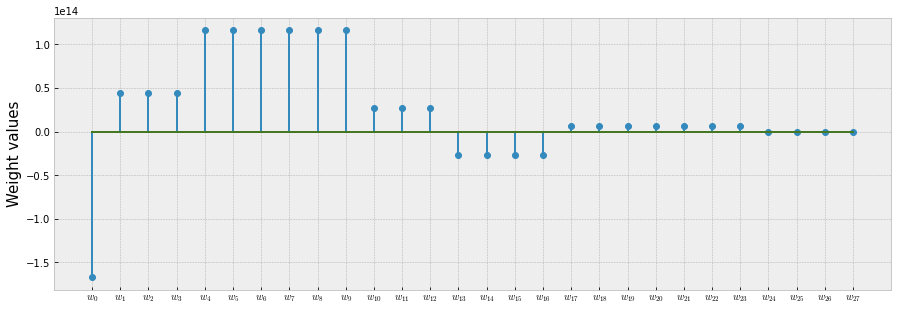

In [17]:
plt.figure(figsize=(15,5))
plt.stem(w)
plt.ylabel('Weight values', size=15)
plt.xticks(np.arange(len(w)), ['$w_{'+str(i)+'}$' for i in range(len(w))],rotation=0);

Column, Number of weights describing it: Intercept 1, Branch 3, Product Line 6, Payment Type 3, Time of Day 4, day of week 7, Gender 1, Customer type 1, Quantity 1, unit price 1

As seen in the Weight Values output above, the two most impactful features for predicting the gross income were the Product Line and the Branch. Surprisingly, the unit price and quantity features had weight measurements of 0 associated with them. Time of day had a negative weight of approximately the same magnitude as the positive impact payment type has. The day of the week has the smallest non-zero weight of any feature, with a minute positive impact on the prediction. In short, gross income is most affected by Branch and Product line, somewhat impacted by Time of Day and Payment Type, barely impacted by Day of Week, and not impacted by any of customer type, quantity, gender, or unit price. It would appear that when you need to buy something you go and buy it regardless of who you are, or what time of whatever day it is. As such, the gross income is predicted by what product line you get and where you buy it from.

In [33]:
lasso_reg = joblib.load('lasso_gross.pkl')

In [35]:
y_train = lasso_reg.predict(X_train)
y_test = lasso_reg.predict(X_test)

In [36]:
confidence = 0.95 

print(f'Lasso Regression:\n')
final_r2_train = r2_score(t_train, y_train)
print('R2 Train: ', final_r2_train)  
final_r2_test = r2_score(t_test, y_test) 
print('R2 Test: ', final_r2_test)
print()

squared_errors = (t_test - y_test) ** 2 # observation (MSE)  
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,                 
                         loc = squared_errors.mean(),                 
                         scale=squared_errors.std(ddof=1)/np.sqrt(len(squared_errors))))
print('Confidence Interval of 95%')
print(f'{ci}')

Lasso Regression:

R2 Train:  0.8891398572439433
R2 Test:  0.8941466783673888

Confidence Interval of 95%
[3.44404872 4.21471112]


In [21]:
w = np.vstack((lasso_reg.intercept_, lasso_reg.coef_[:,np.newaxis]))
w

array([[15.38471518],
       [-0.        ],
       [-0.        ],
       [ 0.        ],
       [-0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [ 0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.02032478],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.14468844],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [ 0.        ],
       [ 8.10311648],
       [ 7.22662655]])

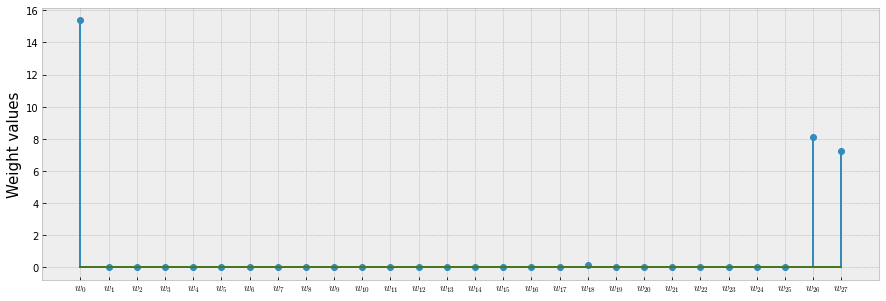

In [22]:
plt.figure(figsize=(15,5))
plt.stem(w)
plt.ylabel('Weight values', size=15)
plt.xticks(np.arange(len(w)), ['$w_{'+str(i)+'}$' for i in range(len(w))],rotation=0);

Column, Number of weights describing it: Intercept 1, Branch 3, Product Line 6, Payment Type 3, Time of Day 4, day of week 7, Gender 1, Customer type 1, Quantity 1, unit price 1

From the hyperparameter tuning in the training notebook, the alpha=0.1 value worked best for this dataset.

As seen in the Weight Values output above, the two most impactful features for predicting the gross income were the Quantity and the Unit Price. It would appear that including the Lasso penalty greatly changes the conclusions drawn from this dataset. Every other feature had a weight of 0 with lasso regularization. In this case it would appear that the gross income is predicted by how much you bought and how much each of those items cost. This is a much more intuitive result than the linear regression one before.

Question 3

In [23]:
num_2scale_attribs = ['Quantity','gross income']
num_orig_attribs = ['Unit price']


train_set_prepared_unit = preprocessing_pipeline.fit_transform(train_data)
test_set_prepared_unit = preprocessing_pipeline.transform(test_data)

In [37]:
t_train = train_set_prepared_unit[:,-1] # unit price was left untouched in the above pipeline
X_train = np.delete(train_set_prepared_unit,-1,1)

t_test = test_set_prepared_unit[:,-1] # unit price was left untouched in the above pipeline
X_test = np.delete(test_set_prepared_unit,-1,1)

In [25]:
lin_reg_unit = joblib.load('lin_reg_unit.pkl')
y_train = lin_reg_unit.predict(X_train)
y_test = lin_reg_unit.predict(X_test)

In [26]:
confidence = 0.95 

print(f'Linear Regression:\n')
final_r2_train = r2_score(t_train, y_train)
print('R2 Train: ', final_r2_train)  
final_r2_test = r2_score(t_test, y_test) 
print('R2 Test: ', final_r2_test)
print()

squared_errors = (t_test - y_test) ** 2 # observation (MSE)  
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,                 
                         loc = squared_errors.mean(),                 
                         scale=squared_errors.std(ddof=1)/np.sqrt(len(squared_errors))))
print('Confidence Interval of 95%')
print(f'{ci}')

Linear Regression:

R2 Train:  0.8912070106359291
R2 Test:  0.889544790976915

Confidence Interval of 95%
[3.53028903 4.295376  ]


In [27]:
w = np.vstack((lin_reg_unit.intercept_, lin_reg_unit.coef_[:,np.newaxis]))

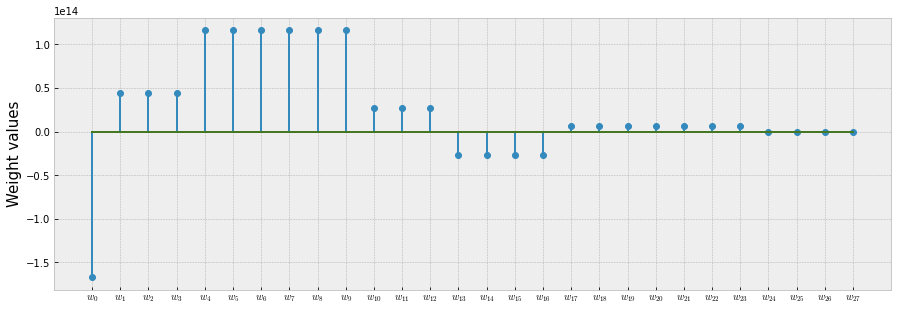

In [28]:
plt.figure(figsize=(15,5))
plt.stem(w)
plt.ylabel('Weight values', size=15)
plt.xticks(np.arange(len(w)), ['$w_{'+str(i)+'}$' for i in range(len(w))],rotation=0);

Column, Number of weights describing it: Intercept 1, Branch 3, Product Line 6, Payment Type 3, Time of Day 4, day of week 7, Gender 1, Customer type 1, Quantity 1, unit price 1

Unsurprisingly, this model predicts in the exact same way as the linear regression model for the gross income. Hence the equivalent analysis.

As seen in the Weight Values output above, the two most impactful features for predicting the unit cost were the Product Line and the Branch. Again, the unit price and quantity features had weight measurements of 0 associated with them. Time of day had a negative weight of approximately the same magnitude as the positive impact payment type has. The day of the week has the smallest non-zero weight of any feature, with a minute positive impact on the prediction. In short, unit cost is most affected by Branch and Product line, somewhat impacted by Time of Day and Payment Type, barely impacted by Day of Week, and not impacted by any of customer type, quantity, gender, or unit price. It would appear that when you need to buy something you go and buy it regardless of who you are, or what time of whatever day it is. As such, the unit cost is predicted by what product line you get and where you buy it from.

In [38]:
lasso_reg = joblib.load('lasso_unit.pkl')
y_train = lasso_reg.predict(X_train)
y_test = lasso_reg.predict(X_test)

confidence = 0.95 

print(f'Lasso Regression:\n')
final_r2_train = r2_score(t_train, y_train)
print('R2 Train: ', final_r2_train)  
final_r2_test = r2_score(t_test, y_test) 
print('R2 Test: ', final_r2_test)
print()

squared_errors = (t_test - y_test) ** 2 # observation (MSE)  
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,                 
                         loc = squared_errors.mean(),                 
                         scale=squared_errors.std(ddof=1)/np.sqrt(len(squared_errors))))
print('Confidence Interval of 95%')
print(f'{ci}')

Lasso Regression:

R2 Train:  0.8891398572439433
R2 Test:  0.8941466783673888

Confidence Interval of 95%
[3.44404872 4.21471112]


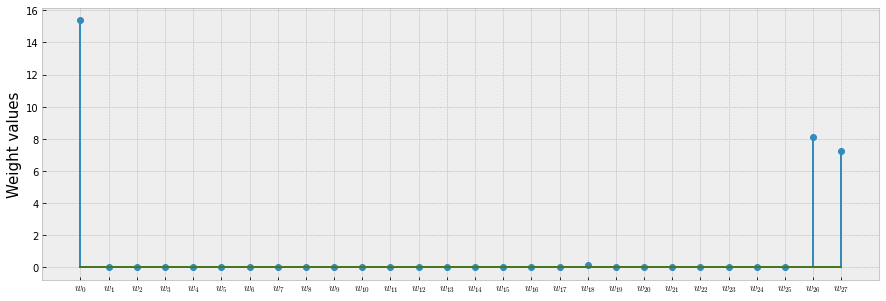

In [39]:
w = np.vstack((lasso_reg.intercept_, lasso_reg.coef_[:,np.newaxis]))
plt.figure(figsize=(15,5))
plt.stem(w)
plt.ylabel('Weight values', size=15)
plt.xticks(np.arange(len(w)), ['$w_{'+str(i)+'}$' for i in range(len(w))],rotation=0);

Column, Number of weights describing it: Intercept 1, Branch 3, Product Line 6, Payment Type 3, Time of Day 4, day of week 7, Gender 1, Customer type 1, Quantity 1, unit price 1

Unsurprisingly, this model predicts in the exact same way as the lasso regression model for the gross income. Hence the equivalent analysis. 

From the hyperparameter tuning in the training notebook, the alpha=0.1 value worked best for this dataset.

As seen in the Weight Values output above, the two most impactful features for predicting the unit cost were the Quantity and the gross income. It would appear that including the Lasso penalty grealty changes the conclusions drawn from this dataset. Every other feature had a weight of 0 with lasso regularization. In this case it would appear that the unit cost is predicted by how much you bought and how much each of those items cost. This is a much more intuitive result than the linear regression one before.

Question 4

In [65]:
cat_1hot_attribs = ['Product line','Payment']
num_2scale_attribs = ['gross income']

attributes_encoder_and_scaling_gender = ColumnTransformer([('cat_1hot', cat_1hot_pipeline, cat_1hot_attribs),
                                                           ('num_2scale', num_2scale_pipeline, num_2scale_attribs)],
                                                            remainder='drop')

X_train = attributes_encoder_and_scaling_gender.fit_transform(train_data[train_data['Branch']=='C'])
t_train = train_data[train_data['Branch']=='C']['Gender']

X_test = attributes_encoder_and_scaling_gender.transform(test_data[test_data['Branch']=='C'])
t_test = test_data[test_data['Branch']=='C']['Gender']

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((259, 10), (259,), (69, 10), (69,))

In [66]:
log_poly = joblib.load('log_poly_gender.pkl')
log_poly

Pipeline(steps=[('poly_feat', PolynomialFeatures(interaction_only=True)),
                ('log_reg', LogisticRegression(penalty='none'))])

In [67]:
poly_X = log_poly.named_steps['poly_feat'].transform(X)
log_poly.named_steps['poly_feat'].powers_

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0,

In [73]:
poly_attributes = ['Intercept']
attrib_names = np.array(['Health and beauty', 'Electronic accessories',
       'Home and lifestyle', 'Sports and travel', 'Food and beverages',
       'Fashion accessories','Ewallet', 'Cash', 'Credit card','gross income'])
N_attributes = log_poly.named_steps['poly_feat'].powers_.shape[0]

for i in range(1,N_attributes):
    temp = attrib_names[log_poly.named_steps['poly_feat'].powers_[i,:]==1]
    
    if len(temp)==1:
        poly_attributes += [temp[0]]
    else:
        poly_attributes += [temp[0]+' + '+temp[1]]
        
poly_attributes = np.array(poly_attributes).reshape(-1,1)

poly_attributes.shape

(56, 1)

In [74]:
poly_attributes

array([['Intercept'],
       ['Health and beauty'],
       ['Electronic accessories'],
       ['Home and lifestyle'],
       ['Sports and travel'],
       ['Food and beverages'],
       ['Fashion accessories'],
       ['Ewallet'],
       ['Cash'],
       ['Credit card'],
       ['gross income'],
       ['Health and beauty + Electronic accessories'],
       ['Health and beauty + Home and lifestyle'],
       ['Health and beauty + Sports and travel'],
       ['Health and beauty + Food and beverages'],
       ['Health and beauty + Fashion accessories'],
       ['Health and beauty + Ewallet'],
       ['Health and beauty + Cash'],
       ['Health and beauty + Credit card'],
       ['Health and beauty + gross income'],
       ['Electronic accessories + Home and lifestyle'],
       ['Electronic accessories + Sports and travel'],
       ['Electronic accessories + Food and beverages'],
       ['Electronic accessories + Fashion accessories'],
       ['Electronic accessories + Ewallet'],
       ['

In [75]:
w = log_poly.named_steps['log_reg'].coef_.T

w

array([[-0.06514934],
       [ 0.02189693],
       [-0.08154349],
       [-0.07377037],
       [ 0.32459017],
       [ 0.14370353],
       [-0.40002612],
       [ 0.03499141],
       [-0.2105449 ],
       [ 0.11040414],
       [-0.13160313],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.21646341],
       [-0.76585906],
       [ 0.57129257],
       [ 0.35176203],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.54379475],
       [-0.20391504],
       [-0.42142319],
       [ 0.10192932],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.04287282],
       [-0.0726149 ],
       [-0.04402829],
       [-0.24602424],
       [ 0.        ],
       [ 0.        ],
       [-0.01968156],
       [ 0.62238294],
       [-0.2781112 ],
       [ 0.4729714 ],
       [ 0.        ],
       [-0.26717   ],
       [-0.10987591],
       [ 0.52074944],
       [-0

In [88]:
Interactions = pd.DataFrame(np.hstack((poly_attributes,w)), columns=['Attributes', 'Coefficients'])
Interactions[Interactions['Coefficients']!='0.0'].sort_values('Coefficients')

,Attributes,Coefficients
37,Sports and travel + Ewallet,-0.019681563646940216
33,Home and lifestyle + Credit card,-0.04402829347806182
0,Intercept,-0.0651493440528126
32,Home and lifestyle + Cash,-0.07261489927996907
3,Home and lifestyle,-0.07377036970203125
2,Electronic accessories,-0.08154348888371056
43,Food and beverages + Cash,-0.10987591215410723
54,Cash + gross income,-0.11593422634977228
45,Food and beverages + gross income,-0.12577528172014904
10,gross income,-0.13160313329447823


Looking into the Attribute and Coefficient table above, we see that the strongest negative and positive relations to predicting gender lay in the combination of Product Line and another feature, whether it be payment method or gross income.

In [93]:
X_train = attributes_encoder_and_scaling_gender.fit_transform(train_data[(train_data['Branch']=='C') & (train_data['Gender']=='Male')])
t_train = train_data[(train_data['Branch']=='C') & (train_data['Gender']=='Male')]['Gender']

X_test = attributes_encoder_and_scaling_gender.transform(test_data[(test_data['Branch']=='C') & (test_data['Gender']=='Male')])
t_test = test_data[(test_data['Branch']=='C') & (test_data['Gender']=='Male')]['Gender']

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((122, 10), (122,), (28, 10), (28,))

In [94]:
poly_X = log_poly.named_steps['poly_feat'].transform(X_train)
log_poly.named_steps['poly_feat'].powers_

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0,

In [96]:
w = log_poly.named_steps['log_reg'].coef_.T
poly_attributes = ['Intercept']
attrib_names = np.array(['Health and beauty', 'Electronic accessories',
       'Home and lifestyle', 'Sports and travel', 'Food and beverages',
       'Fashion accessories','Ewallet', 'Cash', 'Credit card','gross income'])
N_attributes = log_poly.named_steps['poly_feat'].powers_.shape[0]

for i in range(1,N_attributes):
    temp = attrib_names[log_poly.named_steps['poly_feat'].powers_[i,:]==1]
    
    if len(temp)==1:
        poly_attributes += [temp[0]]
    else:
        poly_attributes += [temp[0]+' + '+temp[1]]
        
poly_attributes = np.array(poly_attributes).reshape(-1,1)

Interactions = pd.DataFrame(np.hstack((poly_attributes,w)), columns=['Attributes', 'Coefficients'])
Interactions[Interactions['Coefficients']!='0.0'].sort_values('Coefficients')

,Attributes,Coefficients
37,Sports and travel + Ewallet,-0.019681563646940216
33,Home and lifestyle + Credit card,-0.04402829347806182
0,Intercept,-0.0651493440528126
32,Home and lifestyle + Cash,-0.07261489927996907
3,Home and lifestyle,-0.07377036970203125
2,Electronic accessories,-0.08154348888371056
43,Food and beverages + Cash,-0.10987591215410723
54,Cash + gross income,-0.11593422634977228
45,Food and beverages + gross income,-0.12577528172014904
10,gross income,-0.13160313329447823


Plotting the parameter values for all attributes and the 2nd order interactions, for just Gender=male customers, yields roughly the same information as plotting the original attribute table above used to study the relationship between all the attributes. We still find that no single attribute is useful to much degree, but the combination of a Product line with a Payment method, or in 1 case gross income, yields useful information about the gender of the shopper.

Question 5

In [97]:
cat_1hot_attribs = ['time_of_day','day_of_week']
cat_int_attribs = ['Gender']

attribute_organizer = Pipeline([('attribs_organizer', AttributesOrganizer())])

attributes_encoder_and_scaling_gender = ColumnTransformer([('cat_1hot', cat_1hot_pipeline, cat_1hot_attribs),
                                                           ('cat_int', cat_int_pipeline, cat_int_attribs)],
                                                            remainder='drop')

preprocessing_pipeline_cust = Pipeline([('attributes', attribute_organizer),
                                        ('encod_and_scale', attributes_encoder_and_scaling_gender)])

X = preprocessing_pipeline_cust.fit_transform(train_data[train_data['Branch']=='C'])
t = train_data[train_data['Branch']=='C']['Customer type']
X.shape, t.shape

((259, 12), (259,))

In [102]:
log_poly = joblib.load('log_poly_cust.pkl')
poly_X = log_poly.named_steps['poly_feat'].transform(X)
log_poly.named_steps['poly_feat'].powers_

poly_attributes = ['Intercept']
attrib_names = np.array(['Morning','Afternoon','Evening', 'Night',
                         'Mon','Tues','Wed','Thurs','Fri','Sat','Sun', 'Gender'])
N_attributes = log_poly.named_steps['poly_feat'].powers_.shape[0]

for i in range(1,N_attributes):
    temp = attrib_names[log_poly.named_steps['poly_feat'].powers_[i,:]==1]
    
    if len(temp)==1:
        poly_attributes += [temp[0]]
    else:
        poly_attributes += [temp[0]+' + '+temp[1]]
        
poly_attributes = np.array(poly_attributes).reshape(-1,1)

poly_attributes.shape

(79, 1)

In [103]:
w = log_poly.named_steps['log_reg'].coef_.T
Interactions = pd.DataFrame(np.hstack((poly_attributes,w)), columns=['Attributes', 'Coefficients'])
Interactions[Interactions['Coefficients']!='0.0'].sort_values('Coefficients')

,Attributes,Coefficients
28,Afternoon + Wed,-0.04496249500180928
17,Morning + Tues,-0.052936426003739656
49,Night + Sun,-0.13154431476050793
68,Wed + Gender,-0.16684280085203654
6,Tues,-0.28891362136592247
18,Morning + Wed,-0.31607734644610186
0,Intercept,-0.39660257677885113
45,Night + Wed,-0.40749797371254676
46,Night + Thurs,-0.4291976397984431
57,Mon + Gender,-0.4681876995604329


Looking into the Attribute and Coefficient table above, we see that the strongest negative and positive relations to predicting gender lay in specifically which Day of Week as well as the combination of Day of Week and Time of Day. Monday Evening is very strongly negative, and Monday Night is strongly positive. Add in the Afternoon, Sunday, and Friday to cover the strongest positive and negative relations. Nothing comes close to Monday evening in terms of coefficient magnitude for predicting customer type. We find the Day of Week combined with the Time of Day to be the strongest interaction.

In [110]:
X_train = preprocessing_pipeline_cust.fit_transform(train_data[(train_data['Branch']=='C') & (train_data['Customer type']=='Normal')])
t_train = train_data[(train_data['Branch']=='C') & (train_data['Customer type']=='Normal')]['Gender']

X_test = preprocessing_pipeline_cust.transform(test_data[(test_data['Branch']=='C') & (test_data['Customer type']=='Normal')])
t_test = test_data[(test_data['Branch']=='C') & (test_data['Customer type']=='Normal')]['Gender']

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((123, 12), (123,), (36, 12), (36,))

In [111]:
log_poly = joblib.load('log_poly_cust.pkl')
poly_X = log_poly.named_steps['poly_feat'].transform(X)
log_poly.named_steps['poly_feat'].powers_

poly_attributes = ['Intercept']
attrib_names = np.array(['Morning','Afternoon','Evening', 'Night',
                         'Mon','Tues','Wed','Thurs','Fri','Sat','Sun', 'Gender'])
N_attributes = log_poly.named_steps['poly_feat'].powers_.shape[0]

for i in range(1,N_attributes):
    temp = attrib_names[log_poly.named_steps['poly_feat'].powers_[i,:]==1]
    
    if len(temp)==1:
        poly_attributes += [temp[0]]
    else:
        poly_attributes += [temp[0]+' + '+temp[1]]
        
poly_attributes = np.array(poly_attributes).reshape(-1,1)

poly_attributes.shape

(79, 1)

In [112]:
w = log_poly.named_steps['log_reg'].coef_.T
Interactions = pd.DataFrame(np.hstack((poly_attributes,w)), columns=['Attributes', 'Coefficients'])
Interactions[Interactions['Coefficients']!='0.0'].sort_values('Coefficients')

,Attributes,Coefficients
28,Afternoon + Wed,-0.04496249500180928
17,Morning + Tues,-0.052936426003739656
49,Night + Sun,-0.13154431476050793
68,Wed + Gender,-0.16684280085203654
6,Tues,-0.28891362136592247
18,Morning + Wed,-0.31607734644610186
0,Intercept,-0.39660257677885113
45,Night + Wed,-0.40749797371254676
46,Night + Thurs,-0.4291976397984431
57,Mon + Gender,-0.4681876995604329


Plotting the parameter values for all attributes and the 2nd order interactions, for just Customer type=normal customers, yields roughly the same information as plotting the original attribute table above used to study the relationship between all the attributes. We still find the Day of Week combined with the Time of Day to be the strongest interaction.

Question 6

In [117]:
cat_1hot_attribs = ['Branch', 'Product line','Payment','time_of_day']
cat_int_attribs = ['Gender','Customer type']
num_2scale_attribs = ['Quantity','Unit price']
num_orig_attribs = ['gross income']

X_train = preprocessing_pipeline.fit_transform(train_data)
t_train = pd.to_datetime(train_data['Date']).dt.dayofweek
X_test = preprocessing_pipeline.transform(test_data)
t_test = pd.to_datetime(test_data['Date']).dt.dayofweek

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((800, 28), (800,), (200, 28), (200,))

In [118]:
log_day = joblib.load('log_day.pkl')
y_train_log = log_day.predict(X_train)
y_test_log = log_day.predict(X_test)

In [121]:
confidence = 0.95 

print(f'Linear Regression:\n')
final_r2_train = accuracy_score(t_train, y_train_log)
print('Train Accuracy: ', final_r2_train)  
final_r2_test = accuracy_score(t_test, y_test_log) 
print('Test Accuracy: ', final_r2_test)
print()

squared_errors = (t_test - y_test_log) ** 2 # observation (MSE)  
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,                 
                         loc = squared_errors.mean(),                 
                         scale=squared_errors.std(ddof=1)/np.sqrt(len(squared_errors))))
print('Confidence Interval of 95%')
print(f'{ci}')

Linear Regression:

Train Accuracy:  1.0
Test Accuracy:  1.0

Confidence Interval of 95%
[nan nan]


For the Logistic Regression Classifier, the optimal hyperparameters turned out to be the default parameters with a penalty of None. However given the Accuracy of 100% on both train and test, I fear that it may have overfit the data. That or the predictions are just so simple that the model can easily get it right everytime.

In [122]:
grad_day = joblib.load('grad_day.pkl')
y_train = grad_day.predict(X_train)
y_test = grad_day.predict(X_test)

In [123]:
confidence = 0.95 

print(f'Linear Regression:\n')
final_r2_train = accuracy_score(t_train, y_train)
print('Train Accuracy: ', final_r2_train)  
final_r2_test = accuracy_score(t_test, y_test) 
print('Test Accuracy: ', final_r2_test)
print()

squared_errors = (t_test - y_test_log) ** 2 # observation (MSE)  
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,                 
                         loc = squared_errors.mean(),                 
                         scale=squared_errors.std(ddof=1)/np.sqrt(len(squared_errors))))
print('Confidence Interval of 95%')
print(f'{ci}')

Linear Regression:

Train Accuracy:  1.0
Test Accuracy:  1.0

Confidence Interval of 95%
[nan nan]


For the Gradient Boosting Classifier, the optimal hyperparameters turned out to be the default parameters with a learning rate of 0.001 and a subsample rate of 0.5. However given the Accuracy of 100% on both train and test, I fear that it may have overfit the data. That or the predictions are just so simple that the model can easily get it right everytime.